### Arijit's Setup

In [1]:
import bayes3d as b
import numpy as np
import os
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import pybullet as p
print(os.getcwd(), "this is the current working directory")

def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=True)
    return HTML(anim.to_html5_video())

def object_pose_in_camera_frame(object_id, view_matrix):
    object_pos, object_orn = p.getBasePositionAndOrientation(object_id) # world frame
    world2cam = np.array(view_matrix).reshape([4,4]).T # world --> cam 
    object_transform_matrix = np.eye(4)
    object_transform_matrix[:3, :3] = np.reshape(p.getMatrixFromQuaternion(object_orn), (3, 3))
    object_transform_matrix[:3, 3] = object_pos
    return world2cam @ object_transform_matrix

def get_camera_pose(view_matrix):
    # cam2world
    world2cam = np.array(view_matrix)
    cam2world  = np.linalg.inv(world2cam)
    return cam2world

def object_pose_in_camera_frame(object_pose, view_matrix):
    world2cam = np.array(view_matrix).reshape([4,4]) # world --> cam 
    return world2cam @ object_pose

/home/ubuntu/bayes3d/test this is the current working directory


pybullet build time: May 20 2022 19:44:17


Pybullet Scene Sim with Collisons

In [6]:
import bayes3d.utils.pybullet_sim as pyb 

scene = pyb.Scene()
scene.set_gravity([0, 0, 0])
scene.set_timestep(1/240)
scene.set_downsampling(4) 

occ1_meshscale = [0.07,0.07,0.07]
path_to_obj = "../assets/sample_objs/plane.obj"
base_position = [0,-1,1]
base_orientation = [0.7071068, 0, 0, 0.7071068]
base_orientation = np.array(p.getMatrixFromQuaternion(base_orientation)).reshape(3,3)
occ1 = pyb.make_body_from_obj(path_to_obj, base_position, orientation=base_orientation,scale = occ1_meshscale, id = "occluder")
occ1.set_mass(0)
occ1.set_color([0.5,0.5,0.5])
scene.add_body(occ1)

box_mass = 1
path_to_box = "../assets/sample_objs/cube.obj"
box_position = [-3.25, 0, 1]
box_start_velocity = [6, 0, 0]
mesh_scale = [0.5,0.5,0.5]
box = pyb.make_body_from_obj(path_to_box, box_position, scale = mesh_scale, restitution=1, id = "box1")
box.set_velocity(box_start_velocity)
scene.add_body(box)

box2_position = [3.25, 0, 1]
box2_start_velocity = [-6, 0, 0]
box2 = pyb.make_body_from_obj(path_to_box, box2_position, scale = mesh_scale, restitution=1, id = "box2")
box2.set_velocity(box2_start_velocity)
box2.set_color([0.5,0.5,0.5])
scene.add_body(box2)

bull = scene.simulate(220, defaultView = True)
bull.create_gif("tracking_collision.gif")

In [8]:
box1_poses = bull.get_body_poses()["box1"]
box2_poses = bull.get_body_poses()["box2"]
plane_pos, plane_ori = bull.floor_pos_ori
plane_ori = p.getMatrixFromQuaternion(plane_ori)
plane_cam_pose = np.eye(4)
plane_cam_pose[:3, 3] = plane_pos
plane_cam_pose[:3, :3] = np.array(plane_ori).reshape(3,3)
view_matrix = bull.viewMatrix 
view_matrix = np.array(view_matrix).reshape([4,4]).T
box1 = [view_matrix@pose for pose in box1_poses]
box2 = [view_matrix@pose for pose in box2_poses]
plane_cam_poses = view_matrix@plane_cam_pose
occ1_pose = view_matrix@ bull.get_body_poses()['occluder'][0]
cam_pose = get_camera_pose(view_matrix) 

Required Information for Tracking

In [9]:
array_dict = {
    'sphere1': box1, # box poses in camera view 
    'sphere2': box2, # sphere2 poses in camera view
    'plane': plane_cam_pose, # plane pose in camera view 
    'occ1' : occ1_pose, # occluder pose in camera view
    'occ1_meshscale' : occ1_meshscale,
    'cam_pose' : cam_pose, # camera pose in world view
}

np.savez('scene_npzs/collision_scene_demo.npz', **array_dict)

In [10]:
# sanity checks 

print(occ1_pose)
print(cam_pose)

[[ 1.          0.          0.          0.        ]
 [ 0.          0.99619472 -0.08715574  0.90903898]
 [ 0.          0.08715574  0.99619472 -4.91664954]
 [ 0.          0.          0.          1.        ]]
[[ 1.          0.          0.          0.        ]
 [-0.          0.08715574 -0.99619468 -5.97716806]
 [ 0.          0.99619468  0.08715574  0.52293444]
 [ 0.          0.          0.          1.        ]]


Tracking Setup


In [1]:
import bayes3d as b
import bayes3d.transforms_3d as t3d
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from jax.debug import print as jprint
import physics_priors as p
import importlib
importlib.reload(p)
import time
import PIL.Image
from math import sqrt
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import plotly.graph_objects as go
%matplotlib inline 

In [2]:
intrinsics = b.Intrinsics(
    height=360,
    width=480,
    fx=180*sqrt(3), fy=180*sqrt(3),
    cx=240.0, cy=180.0,
    near=0.1, far=10.0
)
b.setup_renderer(intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (480, 384, 1024)


In [3]:
loaded_poses = np.load('scene_npzs/collision_scene_demo.npz')
# Find number of timesteps
N_tsteps = loaded_poses['sphere1'].shape[0]

# load occluder poses into (N,4,4)
occ1_meshscale = loaded_poses['occ1_meshscale']
# occ1_meshscale = [0.0667,0.0667,0.0667]
occ1_pose = loaded_poses['occ1']
occ1_pose[1:3] *= -1
occ1_poses = jnp.tile(jnp.array(occ1_pose), (N_tsteps,1,1))

# occ2_meshscale = loaded_poses['occ2_meshscale']
# occ2_pose = loaded_poses['occ2']
# occ2_pose[1:3] *= -1
# occ2_poses = jnp.tile(jnp.array(occ2_pose), (N_tsteps,1,1))

# get object poses
gt_poses = loaded_poses['sphere1']
gt_poses[:,1:3,:] *= -1 # CV2 convention
gt_poses = jnp.array(gt_poses)

gt_collision_poses = loaded_poses['sphere2']
gt_collision_poses[:,1:3,:] *= -1 # CV2 convention
gt_collision_poses = jnp.array(gt_collision_poses)

# combine the poses
# total_gt_poses = jnp.stack([gt_poses, occ1_poses, occ2_poses], axis = 1)
total_gt_poses = jnp.stack([gt_poses,gt_collision_poses,occ1_poses], axis = 1)

# cv2 convention of cam pose
world2cam = np.linalg.inv(loaded_poses['cam_pose'])
world2cam[1:3] *= -1
cam_pose = jnp.linalg.inv(jnp.array(world2cam)) 

b.RENDERER.add_mesh_from_file("../assets/sample_objs/cube.obj",mesh_name="sphere_1", scaling_factor=[0.5,0.5,0.5])
b.RENDERER.add_mesh_from_file("../assets/sample_objs/cube.obj",mesh_name="sphere_1", scaling_factor=[0.5,0.5,0.5])
b.RENDERER.add_mesh_from_file("../assets/sample_objs/plane.obj",mesh_name="occluder1", scaling_factor=occ1_meshscale)

In [4]:
# gt_images = jax.vmap(b.RENDERER.render_single_object, in_axes=(0, None))(gt_poses, jnp.int32(0))
pose_estimate = gt_poses[0]

# gt_images = b.RENDERER.render_multiobject_parallel(total_gt_poses, [0,1,2])

gt_images = b.RENDERER.render_many(total_gt_poses,jnp.array([0,1,2]))

# gt_images = jax.vmap(b.RENDERER.render, in_axes=(0, None))(gt_poses[:,None, ...], jnp.array([0]))
depths = [b.viz.get_depth_image(gt_images[i,:,:,2]) for i in range(gt_images.shape[0])]

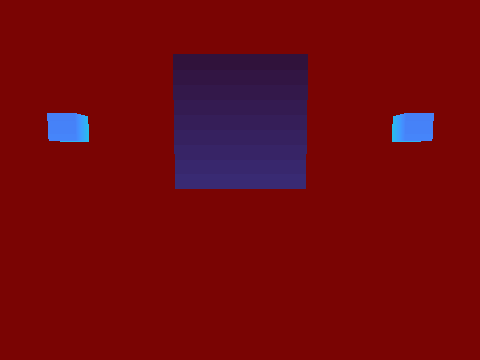

In [5]:
depths[0]

In [6]:
dx, dy, dz = 0.2, 0.2, 0.2
translation_deltas = b.utils.make_translation_grid_enumeration(-dx, -dy, -dz, dx, dy, dz, 5,5,5)


dx, dy, dz = 2, 2, 2
gridding = [
    b.utils.make_translation_grid_enumeration(
        -dx, -dy, -dz, dx, dy, dz, 5,5,5
    ),
    b.utils.make_translation_grid_enumeration(
        -dx/2.0, -dy/2, -dz/2, dx/2, dy/2, dz/2, 5,5,5
    ),
    b.utils.make_translation_grid_enumeration(
        -dx/10.0, -dy/10, -dz/10, dx/10, dy/10, dz/10, 5,5,5
    ),
]

key = jax.random.PRNGKey(314)
rotation_deltas = jax.vmap(lambda key: b.distributions.gaussian_vmf_zero_mean(key, 0.00001, 800.0))(
    jax.random.split(key, 100)
)

# len_proposals = gridding[0].shape[0]
len_proposals = translation_deltas.shape[0]

occ1_poses_trans = jnp.tile(occ1_pose, (len_proposals, 1, 1))
# occ2_poses_trans = jnp.tile(occ2_pose, (len_proposals, 1, 1))

occ1_poses_rot = jnp.tile(occ1_pose, (rotation_deltas.shape[0], 1, 1))
# occ2_poses_rot = jnp.tile(occ2_pose, (rotation_deltas.shape[0], 1, 1))

In [7]:
def update_pose_estimate(memory, gt_image):

    pose_memory, T = memory
    old_pose_estimate = pose_memory[T,...]
    prev_pose = pose_memory[T-1,...]

    threedp3_weight = 1
    proposals = jnp.einsum("ij,ajk->aik", old_pose_estimate, translation_deltas)
    rendered_images = b.RENDERER.render_many(jnp.stack([proposals, occ1_poses_trans],axis = 1), jnp.array([0,1]))
    threedp3_scores = threedp3_weight * b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.001, 0.1, 10**3, 3)
    unique_best_3dp3_score = jnp.sum(threedp3_scores == threedp3_scores[jnp.argmax(threedp3_scores)]) == 1

    physics_weight = jax.lax.cond(unique_best_3dp3_score, lambda _ : 5000, lambda _ : 10000, None)
    # physics_weight = 0

    physics_estimated_pose = p.physics_prior_v1_jit(old_pose_estimate, prev_pose, jnp.array([1,1,1]), cam_pose, world2cam)

    physics_scores = jax.lax.cond(jnp.greater(T, 1), 
    lambda _ : physics_weight * p.physics_prior_parallel_jit(proposals, physics_estimated_pose), 
    lambda _ : jnp.zeros(threedp3_scores.shape[0]), 
    None)

    scores = threedp3_scores + physics_scores

    pose_estimate = proposals[jnp.argmax(scores)]
    pose_memory = pose_memory.at[T+1,...].set(pose_estimate)

    pose_world = cam_pose @ pose_estimate
    gt_pose_world = cam_pose @ gt_poses[T-1]
    jprint("{}: {}, {}", T, unique_best_3dp3_score, pose_world[:3,3])
    jprint("{}: GT, {}\n", T, gt_pose_world[:3,3])

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    # rendered_images = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_rot]), jnp.array([0,1]))
    # # rendered_images = jax.vmap(b.RENDERER.render_single_object, in_axes=(0, None))(proposals, jnp.int32(0))
    # weights_new = b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.05, 0.1, 10**3, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    return (pose_memory, T+1), pose_estimate

In [8]:
importlib.reload(p)
inference_program = jax.jit(lambda p,x: jax.lax.scan(
    update_pose_estimate, 
    (jnp.tile(p, (x.shape[0]+1,1,1)),1),
    x)[1])

start = time.time()
inferred_poses = inference_program(gt_poses[0], gt_images)
end = time.time()
print ("Time elapsed:", end - start)
print ("FPS:", gt_poses.shape[0] / (end - start))

1: True, [-3.2500000e+00 -4.7683716e-07  1.0000000e+00]
1: GT, [-3.2500000e+00 -4.7683716e-07  1.0000000e+00]

2: True, [-3.1500001e+00 -4.7683716e-07  1.0000000e+00]
2: GT, [-3.1500001e+00 -4.7683716e-07  1.0000000e+00]

3: True, [-3.0500002e+00 -4.7683716e-07  1.0000000e+00]
3: GT, [-3.0500000e+00 -4.7683716e-07  1.0000000e+00]

4: True, [-2.9500003e+00 -4.7683716e-07  1.0000000e+00]
4: GT, [-2.9500000e+00 -4.7683716e-07  1.0000000e+00]

5: True, [-2.8500004e+00 -4.7683716e-07  1.0000000e+00]
5: GT, [-2.8499999e+00 -4.7683716e-07  1.0000000e+00]

6: True, [-2.7500005e+00 -4.7683716e-07  1.0000000e+00]
6: GT, [-2.7500000e+00 -4.7683716e-07  1.0000000e+00]

7: True, [-2.6500006e+00 -4.7683716e-07  1.0000000e+00]
7: GT, [-2.6500001e+00 -4.7683716e-07  1.0000000e+00]

8: True, [-2.5500007e+00 -4.7683716e-07  1.0000000e+00]
8: GT, [-2.5500000e+00 -4.7683716e-07  1.0000000e+00]

9: True, [-2.4500008e+00 -4.7683716e-07  1.0000000e+00]
9: GT, [-2.4500000e+00 -4.7683716e-07  1.0000000e+00]

1

In [10]:
.shape

(55, 2, 4, 4)

In [16]:
viz_images = []
max_depth = 10.0

# inferred_poses_with_occ = jnp.stack([inferred_poses, occ1_poses], axis = 1)
occ_image = b.viz.get_depth_image(b.RENDERER.render(occ1_pose[None,...], jnp.array([2]))[:,:,2])

pred_images = b.RENDERER.render_many(inferred_poses[:,None, ...], jnp.array([0]))

pred_with_occ_images = [b.overlay_image(b.viz.get_depth_image(pred_images[i,:,:,2]), 
occ_image, alpha=0.4) for i in range(pred_images.shape[0])]

# gt_images = b.RENDERER.render_many(gt_poses[:,None, ...], jnp.array([0]))
gt_images = b.RENDERER.render_many(total_gt_poses[:,:2,:,:],jnp.array([0,1]))
gt_with_occ_images = [b.overlay_image(b.viz.get_depth_image(gt_images[i,:,:,2]), occ_image, alpha=0.5) for i in range(pred_images.shape[0])]

viz_images = [
    b.viz.multi_panel(
        [g, b.viz.get_depth_image(p[:,:,2]), po],
        labels = ["Ground Truth", "Reconstruction w/o Occluder", "Reconstruction w Occluder"],
        title = "Collision Scene Demo",
        # bottom_text = "3DP3 + Physics Prior v1"
    )
    for (g, p, po) in zip(gt_with_occ_images, pred_images, pred_with_occ_images)
]
# display_video(viz_images)

In [17]:
def make_gif(images, filename, fps = 10):
    duration = int(1000/fps)
    images[0].save(
        fp=filename,
        format="GIF",
        append_images=images,
        save_all=True,
        duration=duration,
        loop=0,
    )

make_gif(viz_images, "scene_gifs/collision_scene_demo.gif", fps=20)